# Trabajo Integrador

## Entrega final

En esta entrega trabajaremos con el dataset de siniestros ocurridos 'datos.csv'.

El mismo cuenta con un listado de siniestros ocurridos desde el 1/1/2016 a la actualidad. Se clasifica a los siniestros en dos categorias: si terminaron con incapacidad invalidante o sin incapacidad invalidante.

Se considera incapacidad laboral permanente cuando el daño sufrido por el trabajador le ocasiona una disminución permanente de su capacidad laborativa. Cuando la incapacidad laboral sea definitiva se le abonará al damnificado una indemnización de pago único que dependerá del porcentaje de incapacidad, de la edad y del ingreso base mensual. Cuando el porcentaje sea superior al 50%, adicionalmente, recibirá una suma de pago único. En caso de que la incapacidad sea producto de un accidente de trabajo o enfermedad profesional el damnificado recibirá un 20% adicional del capital como compensación por daño moral.

Las aseguradoras deben constituir una reserva al momento de identificar un siniestro con posibles secuelas invalidantes. Por lo que el trabajo consiste en armar un modelo que permita identificar siniestros que terminen con incapacidad y asegurarse que los médicos evlúen el caso y estimen el porcentaje de incapacidad para de esta manera reservarlo y cumplir con la normativa vigente.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE, chi2, SelectFromModel
import shap as shp

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

In [1]:
import pandas as pd
import numpy as np
import re
import random
from scipy.stats import mode



import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

import pdb

In [2]:
data = pd.read_csv("datos.csv", index_col=0, sep=";")

In [3]:
data.head(2)

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador
Siniestro,,,,,,,,,,,,,,,,,
1,20/8/2020,1,9-oct-20,2,V49.4,917.0,M,15/5/1990 00:00,910015,CS-GPM AT,MENDOZA,0,50,Resto del Sector Público,0,0,privado
2,1/1/2016,2,6-ene-16,1,S09.8,1006.0,M,11/4/1986 00:00,832979,DEL - POSADAS,CHACO,"10307,46",5,Sector Privado,0,0,Clínica


(array([0, 1]), [Text(0, 0, 'F'), Text(1, 0, 'M')])

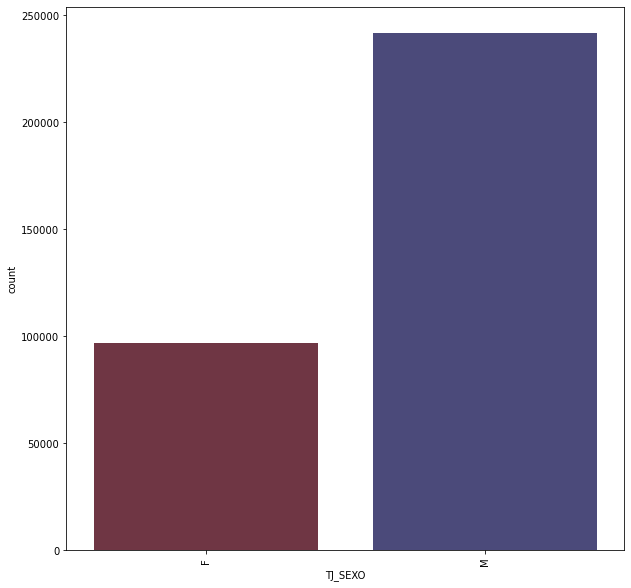

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(x ='TJ_SEXO', data=data, 
              order=data['TJ_SEXO'].value_counts().sort_values().index, 
              palette='icefire_r')
plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'LA PAMPA'),
  Text(1, 0, 'SANTIAGO DEL ESTERO'),
  Text(2, 0, 'SANTA CRUZ'),
  Text(3, 0, 'FORMOSA'),
  Text(4, 0, 'CHACO'),
  Text(5, 0, 'CATAMARCA'),
  Text(6, 0, 'LA RIOJA'),
  Text(7, 0, 'SAN LUIS'),
  Text(8, 0, 'CORRIENTES'),
  Text(9, 0, 'RIO NEGRO'),
  Text(10, 0, 'JUJUY'),
  Text(11, 0, 'TIERRA DEL FUEGO'),
  Text(12, 0, 'MISIONES'),
  Text(13, 0, 'CHUBUT'),
  Text(14, 0, 'NEUQUEN'),
  Text(15, 0, 'ENTRE RIOS'),
  Text(16, 0, 'SALTA'),
  Text(17, 0, 'SAN JUAN'),
  Text(18, 0, 'TUCUMAN'),
  Text(19, 0, 'SANTA FE'),
  Text(20, 0, 'CORDOBA'),
  Text(21, 0, 'MENDOZA'),
  Text(22, 0, 'CAPITAL FEDERAL'),
  Text(23, 0, 'BUENOS AIRES')])

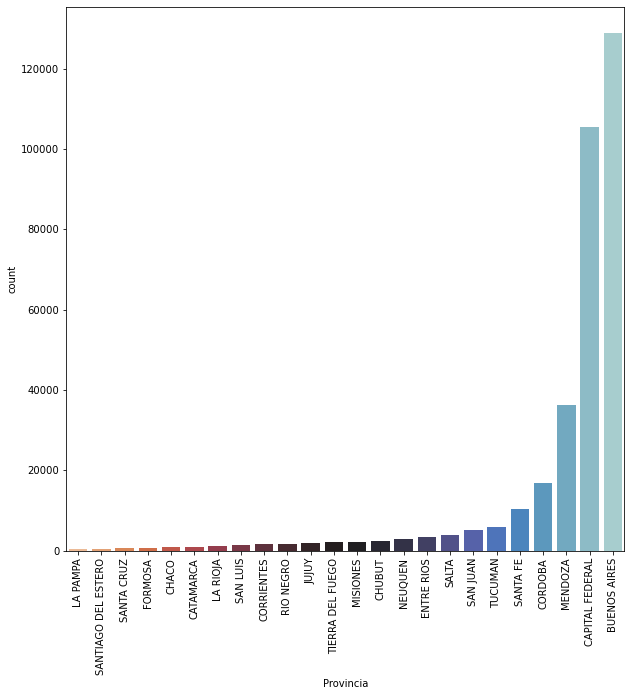

In [6]:
plt.figure(figsize=(10,10))
sns.countplot(x ='Provincia', data=data, 
              order=data['Provincia'].value_counts().sort_values().index, 
              palette='icefire_r')
plt.xticks(rotation=90)


In [ ]:
x3 = frec_weekday.index.tolist()
y3 = frec_weekday.order_count.tolist()

mapa_semana = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
x3 = [mapa_semana[x] for x in x3]
wkmp = {}
for j,x in enumerate(x3):
    wkmp[x] = y3[j]
df_train_week = list(mapa_semana.values())
df_train_vals = [wkmp[val] for val in df_train_week]

plt.figure(figsize=(10,7))
ax=sns.barplot(x=df_train_week,y=df_train_vals, palette=sns.color_palette(palette="Set2"))
ax.set_title("Número total de pedidos por día de la semana")
ax.set_xlabel('Dia')
ax.set_ylabel('Valor')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338748 entries, 1 to 338748
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EX_FECHAACCIDENTE  338748 non-null  object 
 1   EX_TIPO            338748 non-null  int64  
 2   EX_ALTAMEDICA      338748 non-null  object 
 3   EX_GRAVEDAD        338748 non-null  int64  
 4   EX_DIAGNOSTICOOMS  338748 non-null  object 
 5   EX_DELEGACION      338746 non-null  float64
 6   TJ_SEXO            338748 non-null  object 
 7   TJ_FNACIMIENTO     330119 non-null  object 
 8   CIIU.viejo         338748 non-null  int64  
 9   GP_NOMBRE          338747 non-null  object 
 10  Provincia          338748 non-null  object 
 11  PEact              338748 non-null  object 
 12  DiasILT            338748 non-null  int64  
 13  RC_SECTOR          338748 non-null  object 
 14  PresuntaIncap      338748 non-null  int64  
 15  Incapacidad        338748 non-null  int64  
 16  Ti

El dataset incluye los siguientes datos:

•	EX_FECHAACCIDENTE: Fecha en ocurrió el siniestro

•	EX_TIPO: clasifica al siniestro en función de si fue un accidente de trabajo (1), in itinere (2) o enfermedad profesional (3)

•	EX_ALTAMEDICA: Fecha en la que el accidentado recibe el alta médica

•	EX_GRAVEDAD: se clasifica la gravedad del accidentado en 1, 2, 3 o 4 en función de la patología y asistencia médica

•	EX_DIAGNOSTICOOMS: código que describe las secuelas del accidente.

•	EX_DELEGACION: delegación que gestiona el accidente, depende del lugar donde vive el accidentado

•	TJ_SEXO: sexo del accidentado

•	TJ_FNACIMIENTO: fecha de nacimiento del accidentado

•	CIIU.viejo: Código Industrial Internacional Uniforme, describe la actividad de la empresa donde trabaja el accidentado. El primer dígito agrupa las actividades, por ejemplo, el 1 es ganadería 
y pesca.

•	GP_NOMBRE: grupo de trabajo que gestiona los turnos y traslados y consultas del accidentado

•	Provincia: provincia donde vive el accidentado

•	PEact: Prestaciones médicas pagadas actualizadas por el IPC de salud

•	DiasILT: días de baja médica en las que el accidentado no pudo ir a trabajar

•	RC_SECTOR: Sector de la empresa en la que trabaja el accidentado (Privado, Municipalidades, Resto del Sector Público y Gobierno de la Ciudad de Buenos Aires)

•	PresuntaIncap: Al momento de otorgar el alta médica el médico marca si considera que el paciente tiene secuelas invalidantes o no.

•	Incapacidad: variable target. Determina si el accidentado tuvo incapacidad o no

•	Tipo Prestador: prestador que atendió al accidentado.

In [5]:
data.describe()

,EX_TIPO,EX_GRAVEDAD,EX_DELEGACION,CIIU.viejo,DiasILT,PresuntaIncap,Incapacidad
count,338748.000000,338748.000000,338746.000000,338748.000000,338748.000000,338748.000000,338748.000000
mean,1.372504,1.339612,868.915355,722955.575983,40.472333,0.104529,0.218209
std,0.575278,0.601253,56.547610,234228.368552,64.094778,0.305946,0.413031
min,1.000000,1.000000,805.000000,12241.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,840.000000,611018.000000,7.000000,0.000000,0.000000
50%,1.000000,1.000000,840.000000,832952.000000,19.000000,0.000000,0.000000
75%,2.000000,2.000000,917.000000,910015.000000,45.000000,0.000000,0.000000
max,3.000000,4.000000,1026.000000,959944.000000,730.000000,1.000000,1.000000


In [6]:
(data.isnull().sum()/len(data)).round(2)

EX_FECHAACCIDENTE    0.00
EX_TIPO              0.00
EX_ALTAMEDICA        0.00
EX_GRAVEDAD          0.00
EX_DIAGNOSTICOOMS    0.00
EX_DELEGACION        0.00
TJ_SEXO              0.00
TJ_FNACIMIENTO       0.03
CIIU.viejo           0.00
GP_NOMBRE            0.00
Provincia            0.00
PEact                0.00
DiasILT              0.00
RC_SECTOR            0.00
PresuntaIncap        0.00
Incapacidad          0.00
Tipo Prestador       0.00
dtype: float64

In [7]:
data['EX_FECHAACCIDENTE']=pd.to_datetime(data['EX_FECHAACCIDENTE'],errors='coerce')
data['TJ_FNACIMIENTO']=pd.to_datetime(data['TJ_FNACIMIENTO'],errors='coerce')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338748 entries, 1 to 338748
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EX_FECHAACCIDENTE  338748 non-null  datetime64[ns]
 1   EX_TIPO            338748 non-null  int64         
 2   EX_ALTAMEDICA      338748 non-null  object        
 3   EX_GRAVEDAD        338748 non-null  int64         
 4   EX_DIAGNOSTICOOMS  338748 non-null  object        
 5   EX_DELEGACION      338746 non-null  float64       
 6   TJ_SEXO            338748 non-null  object        
 7   TJ_FNACIMIENTO     330119 non-null  datetime64[ns]
 8   CIIU.viejo         338748 non-null  int64         
 9   GP_NOMBRE          338747 non-null  object        
 10  Provincia          338748 non-null  object        
 11  PEact              338748 non-null  object        
 12  DiasILT            338748 non-null  int64         
 13  RC_SECTOR          338748 non-null  object  

In [9]:
data['EDAD_EN_EL_ACCIDENTE']=np.NaN

In [10]:
data["EDAD_EN_EL_ACCIDENTE"] = (data["EX_FECHAACCIDENTE"] - data["TJ_FNACIMIENTO"]).astype('<m8[Y]')

In [11]:
data.head(2)

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador,EDAD_EN_EL_ACCIDENTE
Siniestro,,,,,,,,,,,,,,,,,,
1,2020-08-20,1,9-oct-20,2,V49.4,917.0,M,1990-05-15,910015,CS-GPM AT,MENDOZA,0,50,Resto del Sector Público,0,0,privado,30.0
2,2016-01-01,2,6-ene-16,1,S09.8,1006.0,M,1986-11-04,832979,DEL - POSADAS,CHACO,"10307,46",5,Sector Privado,0,0,Clínica,29.0


In [12]:
patron_num = "\d"
resultado = data['CIIU.viejo'].astype(np.str).apply(lambda x: re.compile(patron_num).findall(x))
numeros_match = resultado.apply(lambda x: x[0])
numeros_match

Siniestro
1         9
2         8
3         9
4         9
5         6
         ..
338744    7
338745    7
338746    7
338747    7
338748    9
Name: CIIU.viejo, Length: 338748, dtype: object

In [13]:
data['PRIMER_DIGITO']=np.NaN

In [14]:
data['PRIMER_DIGITO']=numeros_match

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338748 entries, 1 to 338748
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   EX_FECHAACCIDENTE     338748 non-null  datetime64[ns]
 1   EX_TIPO               338748 non-null  int64         
 2   EX_ALTAMEDICA         338748 non-null  object        
 3   EX_GRAVEDAD           338748 non-null  int64         
 4   EX_DIAGNOSTICOOMS     338748 non-null  object        
 5   EX_DELEGACION         338746 non-null  float64       
 6   TJ_SEXO               338748 non-null  object        
 7   TJ_FNACIMIENTO        330119 non-null  datetime64[ns]
 8   CIIU.viejo            338748 non-null  int64         
 9   GP_NOMBRE             338747 non-null  object        
 10  Provincia             338748 non-null  object        
 11  PEact                 338748 non-null  object        
 12  DiasILT               338748 non-null  int64         
 13 

In [16]:
data.loc[data.TJ_FNACIMIENTO.isnull(),].head(2)

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador,EDAD_EN_EL_ACCIDENTE,PRIMER_DIGITO
Siniestro,,,,,,,,,,,,,,,,,,,
15,2016-01-01,1,4-ene-16,1,F43.1,917.0,F,NaT,910015,CS-GPM AT,MENDOZA,"8154,08",3,Resto del Sector Público,0,0,privado,NaN,9
20,2016-01-01,2,15-ene-16,1,T00.8,840.0,M,NaT,832952,REG. V,BUENOS AIRES,"22546,29",14,Sector Privado,0,0,RES,NaN,8


In [17]:
mask_null= np.logical_and(data.EDAD_EN_EL_ACCIDENTE>18, data.TJ_SEXO=='F')
data.loc[mask_null,:].describe()

,EX_TIPO,EX_GRAVEDAD,EX_DELEGACION,CIIU.viejo,DiasILT,PresuntaIncap,Incapacidad,EDAD_EN_EL_ACCIDENTE
count,93256.000000,93256.000000,93256.000000,93256.000000,93256.000000,93256.000000,93256.000000,93256.000000
mean,1.492322,1.325813,867.377981,845462.954362,39.713488,0.073690,0.165126,40.727642
std,0.603055,0.557618,53.032906,159161.326899,67.495364,0.261267,0.371296,11.544515
min,1.000000,1.000000,805.000000,111112.000000,0.000000,0.000000,0.000000,19.000000
25%,1.000000,1.000000,840.000000,910015.000000,7.000000,0.000000,0.000000,31.000000
50%,1.000000,1.000000,840.000000,910015.000000,18.000000,0.000000,0.000000,40.000000
75%,2.000000,2.000000,917.000000,910015.000000,42.000000,0.000000,0.000000,50.000000
max,3.000000,4.000000,1026.000000,959944.000000,730.000000,1.000000,1.000000,88.000000


In [18]:
mask_null= np.logical_and(data.EDAD_EN_EL_ACCIDENTE>18, data.TJ_SEXO=='M')
data.loc[mask_null,:].describe()

,EX_TIPO,EX_GRAVEDAD,EX_DELEGACION,CIIU.viejo,DiasILT,PresuntaIncap,Incapacidad,EDAD_EN_EL_ACCIDENTE
count,235771.000000,235771.000000,235769.000000,235771.000000,235771.000000,235771.000000,235771.000000,235771.000000
mean,1.327750,1.349644,868.937634,674477.118590,41.803661,0.120672,0.246973,37.178996
std,0.559386,0.622181,57.438943,241495.919284,63.574630,0.325747,0.431252,11.280652
min,1.000000,1.000000,805.000000,12241.000000,0.000000,0.000000,0.000000,19.000000
25%,1.000000,1.000000,840.000000,500038.000000,8.000000,0.000000,0.000000,28.000000
50%,1.000000,1.000000,840.000000,711691.000000,20.000000,0.000000,0.000000,35.000000
75%,2.000000,2.000000,917.000000,910015.000000,49.000000,0.000000,0.000000,45.000000
max,3.000000,4.000000,1026.000000,959944.000000,730.000000,1.000000,1.000000,88.000000


In [19]:
data['PEact'] = data['PEact'].apply(lambda x: x.replace(',','.'))

In [20]:
data['RANGO_PEact']=data.PEact
data.RANGO_PEact= data.RANGO_PEact.astype("float")

In [21]:
mask0= (data.RANGO_PEact>-20000) & (data.RANGO_PEact<100001)
mask1= (data.RANGO_PEact>100000) & (data.RANGO_PEact<500001)
mask2= (data.RANGO_PEact>500000) & (data.RANGO_PEact<2500001)
mask3= data.RANGO_PEact>2500000
data.loc[mask0, "RANGO_PEact"]= 0
data.loc[mask1, "RANGO_PEact"]= 1
data.loc[mask2, "RANGO_PEact"]= 2
data.loc[mask3, "RANGO_PEact"]= 3

In [22]:
data.RANGO_PEact.value_counts()

0.0    306691
1.0     27762
2.0      4033
3.0       262
Name: RANGO_PEact, dtype: int64

In [23]:
mask_m= data.EDAD_EN_EL_ACCIDENTE.isnull() & (data.TJ_SEXO=='M')
data.loc[mask_m, ['EDAD_EN_EL_ACCIDENTE']]= 37

In [24]:
mask_f= data.EDAD_EN_EL_ACCIDENTE.isnull() & (data.TJ_SEXO=='F')
data.loc[mask_f, ['EDAD_EN_EL_ACCIDENTE']]= 40

In [25]:
data.EDAD_EN_EL_ACCIDENTE.isnull().sum()

0

In [26]:
data

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador,EDAD_EN_EL_ACCIDENTE,PRIMER_DIGITO,RANGO_PEact
Siniestro,,,,,,,,,,,,,,,,,,,,
1,2020-08-20,1,9-oct-20,2,V49.4,917.0,M,1990-05-15,910015,CS-GPM AT,MENDOZA,0,50,Resto del Sector Público,0,0,privado,30.0,9,0.0
2,2016-01-01,2,6-ene-16,1,S09.8,1006.0,M,1986-11-04,832979,DEL - POSADAS,CHACO,10307.46,5,Sector Privado,0,0,Clínica,29.0,8,0.0
3,2016-01-01,1,29-ene-16,2,M23,840.0,M,1982-03-14,910015,REG. VI Oeste,BUENOS AIRES,32995.48,28,Municipalidades,0,0,Clínica,33.0,9,0.0
4,2016-01-01,1,2-feb-16,1,M62.0,840.0,F,1970-01-01,910015,REG. VI Oeste,BUENOS AIRES,20291.91,32,Municipalidades,0,0,Clínica,45.0,9,0.0
5,2016-01-01,2,15-ene-16,1,S40.0,917.0,M,1991-04-29,631051,DEL - MENDOZA,MENDOZA,7149.99,14,Sector Privado,0,0,privado,24.0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338744,2019-07-15,3,20-ago-21,2,M65,854.0,M,1963-02-22,711217,DEL EP - CORDOBA,CORDOBA,0,59,Sector Privado,0,0,privado,56.0,7,0.0
338745,2019-07-15,3,13-ago-21,2,M76.5,854.0,M,1963-02-22,711217,DEL EP - CORDOBA,CORDOBA,0,52,Sector Privado,0,0,privado,56.0,7,0.0
338746,2018-08-29,1,17-sep-18,1,S93.4,840.0,M,1987-11-28,711225,CS- AT,CAPITAL FEDERAL,0,19,Sector Privado,0,0,RV,30.0,7,0.0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338748 entries, 1 to 338748
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   EX_FECHAACCIDENTE     338748 non-null  datetime64[ns]
 1   EX_TIPO               338748 non-null  int64         
 2   EX_ALTAMEDICA         338748 non-null  object        
 3   EX_GRAVEDAD           338748 non-null  int64         
 4   EX_DIAGNOSTICOOMS     338748 non-null  object        
 5   EX_DELEGACION         338746 non-null  float64       
 6   TJ_SEXO               338748 non-null  object        
 7   TJ_FNACIMIENTO        330119 non-null  datetime64[ns]
 8   CIIU.viejo            338748 non-null  int64         
 9   GP_NOMBRE             338747 non-null  object        
 10  Provincia             338748 non-null  object        
 11  PEact                 338748 non-null  object        
 12  DiasILT               338748 non-null  int64         
 13 

In [28]:
patron_num = "\w{0,3}"
resultado = data['EX_DIAGNOSTICOOMS'].astype(np.str).apply(lambda x: re.compile(patron_num).findall(x))
numeros_match = resultado.apply(lambda x: x[0])
numeros_match

Siniestro
1         V49
2         S09
3         M23
4         M62
5         S40
         ... 
338744    M65
338745    M76
338746    S93
338747    S90
338748    H90
Name: EX_DIAGNOSTICOOMS, Length: 338748, dtype: object

In [29]:
data['PRIMER_alfanumerico']=np.NaN
data['PRIMER_alfanumerico']=numeros_match

In [30]:
data

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,...,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador,EDAD_EN_EL_ACCIDENTE,PRIMER_DIGITO,RANGO_PEact,PRIMER_alfanumerico
Siniestro,,,,,,,,,,,,,,,,,,,,,
1,2020-08-20,1,9-oct-20,2,V49.4,917.0,M,1990-05-15,910015,CS-GPM AT,...,0,50,Resto del Sector Público,0,0,privado,30.0,9,0.0,V49
2,2016-01-01,2,6-ene-16,1,S09.8,1006.0,M,1986-11-04,832979,DEL - POSADAS,...,10307.46,5,Sector Privado,0,0,Clínica,29.0,8,0.0,S09
3,2016-01-01,1,29-ene-16,2,M23,840.0,M,1982-03-14,910015,REG. VI Oeste,...,32995.48,28,Municipalidades,0,0,Clínica,33.0,9,0.0,M23
4,2016-01-01,1,2-feb-16,1,M62.0,840.0,F,1970-01-01,910015,REG. VI Oeste,...,20291.91,32,Municipalidades,0,0,Clínica,45.0,9,0.0,M62
5,2016-01-01,2,15-ene-16,1,S40.0,917.0,M,1991-04-29,631051,DEL - MENDOZA,...,7149.99,14,Sector Privado,0,0,privado,24.0,6,0.0,S40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338744,2019-07-15,3,20-ago-21,2,M65,854.0,M,1963-02-22,711217,DEL EP - CORDOBA,...,0,59,Sector Privado,0,0,privado,56.0,7,0.0,M65
338745,2019-07-15,3,13-ago-21,2,M76.5,854.0,M,1963-02-22,711217,DEL EP - CORDOBA,...,0,52,Sector Privado,0,0,privado,56.0,7,0.0,M76
338746,2018-08-29,1,17-sep-18,1,S93.4,840.0,M,1987-11-28,711225,CS- AT,...,0,19,Sector Privado,0,0,RV,30.0,7,0.0,S93


In [31]:
patron_let = "\w{0,1}"
resultado = data['PRIMER_alfanumerico'].astype(np.str).apply(lambda x: re.compile(patron_let).findall(x))
numeros_match = resultado.apply(lambda x: x[0])
numeros_match

Siniestro
1         V
2         S
3         M
4         M
5         S
         ..
338744    M
338745    M
338746    S
338747    S
338748    H
Name: PRIMER_alfanumerico, Length: 338748, dtype: object

In [32]:
mask_a= numeros_match=='A'
data.loc[mask_a,"PRIMER_alfanumerico"]= 'A'

In [33]:
mask_f= (numeros_match=='F') & (data.PRIMER_alfanumerico!='F43') & (data.PRIMER_alfanumerico!='F99')
data.loc[mask_f,"PRIMER_alfanumerico"]= 'F'
mask_g= (numeros_match=='G') & (data.PRIMER_alfanumerico!='G56')
data.loc[mask_g,"PRIMER_alfanumerico"]= 'Otro'
mask_h= (numeros_match=='H') & (data.PRIMER_alfanumerico!='H10') & (data.PRIMER_alfanumerico!='H16') & (data.PRIMER_alfanumerico!='H57') & (data.PRIMER_alfanumerico!='H83') & (data.PRIMER_alfanumerico!='H90')
data.loc[mask_h,"PRIMER_alfanumerico"]= 'H'
mask_i= (numeros_match=='I') & (data.PRIMER_alfanumerico!='I83')
data.loc[mask_i,"PRIMER_alfanumerico"]= 'I' 
mask_j= (numeros_match=='J')  & (data.PRIMER_alfanumerico!='J38')
data.loc[mask_j,"PRIMER_alfanumerico"]= 'J'
mask_k= (numeros_match=='K') & (data.PRIMER_alfanumerico!='K40') & (data.PRIMER_alfanumerico!='K92')
data.loc[mask_k,"PRIMER_alfanumerico"]= 'K'
mask_l= (numeros_match=='L') & (data.PRIMER_alfanumerico!='L23') & (data.PRIMER_alfanumerico!='L30')
data.loc[mask_l,"PRIMER_alfanumerico"]= 'L'
mask_m= (data.PRIMER_alfanumerico=='M05') |(data.PRIMER_alfanumerico=='M15') |(data.PRIMER_alfanumerico=='M16')| (data.PRIMER_alfanumerico=='M17')| (data.PRIMER_alfanumerico=='M19')
data.loc[mask_m,"PRIMER_alfanumerico"]= 'M'
mask_m= (data.PRIMER_alfanumerico=='M22') |(data.PRIMER_alfanumerico=='M24') |(data.PRIMER_alfanumerico=='M43')| (data.PRIMER_alfanumerico=='M47')| (data.PRIMER_alfanumerico=='M50')
data.loc[mask_m,"PRIMER_alfanumerico"]= 'M'
mask_m= (data.PRIMER_alfanumerico=='M68') |(data.PRIMER_alfanumerico=='M71') |(data.PRIMER_alfanumerico=='M72')| (data.PRIMER_alfanumerico=='M85')| (data.PRIMER_alfanumerico=='M86')
data.loc[mask_m,"PRIMER_alfanumerico"]= 'M'
mask_m= (data.PRIMER_alfanumerico=='M87') |(data.PRIMER_alfanumerico=='M89') |(data.PRIMER_alfanumerico=='M46') |(data.PRIMER_alfanumerico=='M84')
data.loc[mask_m,"PRIMER_alfanumerico"]= 'M'
mask_n= (numeros_match=='N') & (data.PRIMER_alfanumerico!='N43')
data.loc[mask_n,"PRIMER_alfanumerico"]= 'Otro'
mask_s= (data.PRIMER_alfanumerico=='S0') |(data.PRIMER_alfanumerico=='S03') |(data.PRIMER_alfanumerico=='S04')| (data.PRIMER_alfanumerico=='S07')| (data.PRIMER_alfanumerico=='S08')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S10') |(data.PRIMER_alfanumerico=='S11') |(data.PRIMER_alfanumerico=='S12')| (data.PRIMER_alfanumerico=='S14')| (data.PRIMER_alfanumerico=='S15')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S23') |(data.PRIMER_alfanumerico=='S24') |(data.PRIMER_alfanumerico=='S29')| (data.PRIMER_alfanumerico=='S33')| (data.PRIMER_alfanumerico=='S34')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S35') |(data.PRIMER_alfanumerico=='S36') |(data.PRIMER_alfanumerico=='S37')| (data.PRIMER_alfanumerico=='S38')| (data.PRIMER_alfanumerico=='S39')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S44') |(data.PRIMER_alfanumerico=='S45') |(data.PRIMER_alfanumerico=='S47')| (data.PRIMER_alfanumerico=='S48')| (data.PRIMER_alfanumerico=='S54')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S55') |(data.PRIMER_alfanumerico=='S57') |(data.PRIMER_alfanumerico=='S64')| (data.PRIMER_alfanumerico=='S65')| (data.PRIMER_alfanumerico=='S73')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S75') |(data.PRIMER_alfanumerico=='S76') |(data.PRIMER_alfanumerico=='S77')| (data.PRIMER_alfanumerico=='S78')| (data.PRIMER_alfanumerico=='S84')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_s= (data.PRIMER_alfanumerico=='S85') |(data.PRIMER_alfanumerico=='S87') |(data.PRIMER_alfanumerico=='S88')| (data.PRIMER_alfanumerico=='S94')| (data.PRIMER_alfanumerico=='S98')
data.loc[mask_s,"PRIMER_alfanumerico"]= 'S'
mask_t= (data.PRIMER_alfanumerico=='T0') |(data.PRIMER_alfanumerico=='T04') |(data.PRIMER_alfanumerico=='T05')| (data.PRIMER_alfanumerico=='T07')| (data.PRIMER_alfanumerico=='T08')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T09') |(data.PRIMER_alfanumerico=='T10') |(data.PRIMER_alfanumerico=='T11')| (data.PRIMER_alfanumerico=='T12')| (data.PRIMER_alfanumerico=='T13')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T16') |(data.PRIMER_alfanumerico=='T17') |(data.PRIMER_alfanumerico=='T21')| (data.PRIMER_alfanumerico=='T27')| (data.PRIMER_alfanumerico=='T28')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T34') |(data.PRIMER_alfanumerico=='T52') |(data.PRIMER_alfanumerico=='T53')| (data.PRIMER_alfanumerico=='T55')| (data.PRIMER_alfanumerico=='T56')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T66') |(data.PRIMER_alfanumerico=='T58') |(data.PRIMER_alfanumerico=='T60')| (data.PRIMER_alfanumerico=='T62')| (data.PRIMER_alfanumerico=='T65')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T71') |(data.PRIMER_alfanumerico=='T78') |(data.PRIMER_alfanumerico=='T79')| (data.PRIMER_alfanumerico=='T84')| (data.PRIMER_alfanumerico=='T85')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_t= (data.PRIMER_alfanumerico=='T88') |(data.PRIMER_alfanumerico=='T96') |(data.PRIMER_alfanumerico=='T97')| (data.PRIMER_alfanumerico=='T98')| (data.PRIMER_alfanumerico=='T95')
data.loc[mask_t,"PRIMER_alfanumerico"]= 'T'
mask_y= (numeros_match=='Y') & (data.PRIMER_alfanumerico!='Y96')
data.loc[mask_y,"PRIMER_alfanumerico"]= 'Y'
mask_r= (numeros_match=='R')& (data.PRIMER_alfanumerico!='R10') & (data.PRIMER_alfanumerico!='R49') & (data.PRIMER_alfanumerico!='R52')
data.loc[mask_r,"PRIMER_alfanumerico"]= 'R'
mask_z= (numeros_match=='Z') & (data.PRIMER_alfanumerico!='Z03')& (data.PRIMER_alfanumerico!='Z11')& (data.PRIMER_alfanumerico!='Z13') & (data.PRIMER_alfanumerico!='Z20') & (data.PRIMER_alfanumerico!='Z75')
data.loc[mask_z,"PRIMER_alfanumerico"]= 'Otro'
mask_o= (numeros_match=='B') | (numeros_match=='C') | (numeros_match=='D') | (numeros_match=='E') | (data.PRIMER_alfanumerico=='W23')
data.loc[mask_o,"PRIMER_alfanumerico"]= 'Otro'

In [34]:
mask_grupo= (data.GP_NOMBRE=='DEL EP - BAHIA BLANCA')| (data.GP_NOMBRE=='DEL EP - CATAMARCA')| (data.GP_NOMBRE=='DEL EP - LA RIOJA')| (data.GP_NOMBRE=='DEL EP - PARANA')| (data.GP_NOMBRE=='CS EP- COOR DELEGACIONES')
mask_grupo1= mask_grupo | ((data.GP_NOMBRE=='DEL EP - SAN JUAN')| (data.GP_NOMBRE=='DEL EP - USHUAIA')| (data.GP_NOMBRE=='DELEGACION - EP')| (data.GP_NOMBRE=='INTERIOR EP')| (data.GP_NOMBRE=='ISL-EP'))
data.loc[mask_grupo1,"GP_NOMBRE"]= 'DEL EP'

In [35]:
mask_grupo2= (data.GP_NOMBRE=='CS AT DELEGACION')| (data.GP_NOMBRE=='CS- AT II')| (data.GP_NOMBRE=='CS- EP')| (data.GP_NOMBRE=='CS-DELEGACION')| (data.GP_NOMBRE=='CS-GOB-SAN JUAN EP')
mask_grupo3= mask_grupo2 | ((data.GP_NOMBRE=='CS-REG. V')| (data.GP_NOMBRE=='CS-REG. VI Este')| (data.GP_NOMBRE=='CS-REG. VI Oeste')| (data.GP_NOMBRE=='CS-REG. VII - XII')| (data.GP_NOMBRE=='CS-REG. XIII'))
data.loc[mask_grupo3,"GP_NOMBRE"]= 'CS'

In [36]:
mask_grupo4= (data.GP_NOMBRE=='CRONICOS')| (data.GP_NOMBRE=='CRONICOS DELEGACION')| (data.GP_NOMBRE=='INTERNADOS')| (data.GP_NOMBRE=='PAT-CRON')
data.loc[mask_grupo4,"GP_NOMBRE"]= 'graves'

In [37]:
mask_grupo5= (data.GP_NOMBRE=='Covid 19')| (data.GP_NOMBRE=='DELEGACION')| (data.GP_NOMBRE=='Grupo MONDELEZ')| (data.GP_NOMBRE=='INTERIOR IV')| (data.GP_NOMBRE=='ODONTOLOGÍA')
data.loc[mask_grupo5,"GP_NOMBRE"]= 'otros'

In [38]:
data.to_csv('data_limpio.csv')

In [39]:
pd.set_option('display.max_columns', None)

#### Leemos y analizamos los datos de nuestro dataset

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338748 entries, 1 to 338748
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   EX_FECHAACCIDENTE     338748 non-null  datetime64[ns]
 1   EX_TIPO               338748 non-null  int64         
 2   EX_ALTAMEDICA         338748 non-null  object        
 3   EX_GRAVEDAD           338748 non-null  int64         
 4   EX_DIAGNOSTICOOMS     338748 non-null  object        
 5   EX_DELEGACION         338746 non-null  float64       
 6   TJ_SEXO               338748 non-null  object        
 7   TJ_FNACIMIENTO        330119 non-null  datetime64[ns]
 8   CIIU.viejo            338748 non-null  int64         
 9   GP_NOMBRE             338747 non-null  object        
 10  Provincia             338748 non-null  object        
 11  PEact                 338748 non-null  object        
 12  DiasILT               338748 non-null  int64         
 13 

In [41]:
data.head(5)

,EX_FECHAACCIDENTE,EX_TIPO,EX_ALTAMEDICA,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,TJ_FNACIMIENTO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Incapacidad,Tipo Prestador,EDAD_EN_EL_ACCIDENTE,PRIMER_DIGITO,RANGO_PEact,PRIMER_alfanumerico
Siniestro,,,,,,,,,,,,,,,,,,,,,
1,2020-08-20,1,9-oct-20,2,V49.4,917.0,M,1990-05-15,910015,CS-GPM AT,MENDOZA,0,50,Resto del Sector Público,0,0,privado,30.0,9,0.0,V49
2,2016-01-01,2,6-ene-16,1,S09.8,1006.0,M,1986-11-04,832979,DEL - POSADAS,CHACO,10307.46,5,Sector Privado,0,0,Clínica,29.0,8,0.0,S09
3,2016-01-01,1,29-ene-16,2,M23,840.0,M,1982-03-14,910015,REG. VI Oeste,BUENOS AIRES,32995.48,28,Municipalidades,0,0,Clínica,33.0,9,0.0,M23
4,2016-01-01,1,2-feb-16,1,M62.0,840.0,F,1970-01-01,910015,REG. VI Oeste,BUENOS AIRES,20291.91,32,Municipalidades,0,0,Clínica,45.0,9,0.0,M62
5,2016-01-01,2,15-ene-16,1,S40.0,917.0,M,1991-04-29,631051,DEL - MENDOZA,MENDOZA,7149.99,14,Sector Privado,0,0,privado,24.0,6,0.0,S40


In [42]:
# eliminamos los registros en los que hay datos nulos en muy baja cantidad

data = data.loc[data.GP_NOMBRE.notnull(), :]
data = data.loc[data.EX_DELEGACION.notnull(), :]

In [43]:
# eliminamos las columnas que implican fechas, dado que no es un problema de serie de tiempo, y el dato que surge de las dos columnas eliminadas se encuentra en una diferente
# eliminamos la columna de fecha de nacimiento dado que tenemos la edad de cada persona al momento del accidente

data = data.drop(['EX_ALTAMEDICA', 'EX_FECHAACCIDENTE', 'TJ_FNACIMIENTO'], axis = 1)

In [44]:
data.EX_DELEGACION = data.EX_DELEGACION.astype("str")
data.PRIMER_DIGITO = data.PRIMER_DIGITO.astype("str")

<AxesSubplot:>

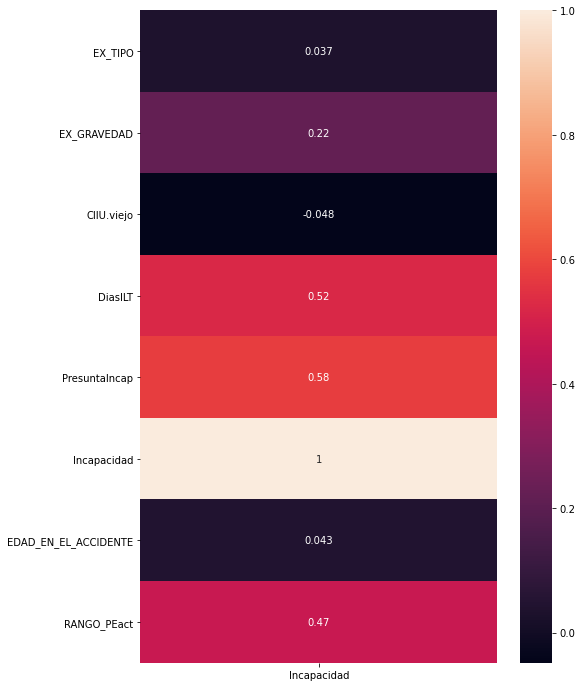

In [45]:
# visualizamos preliminarmente la correlación entre las variables predictoras y la variable target

plt.figure(figsize=(8,12))
sns.heatmap(data.corr()[['Incapacidad']], annot=True)

In [46]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [47]:
#probamos la clase instanciando para una columna
cs = ColumnSelector('Provincia')
cs.transform(data).head()

,Provincia
Siniestro,
1,MENDOZA
2,CHACO
3,BUENOS AIRES
4,BUENOS AIRES
5,MENDOZA


### Data Split

In [48]:
data.shape

(338745, 18)

In [49]:
X = data.drop(['Incapacidad'],axis=1)
y = data['Incapacidad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

In [50]:
X_train.shape

(270996, 17)

### Dummies

In [51]:
categoricals = ['EX_TIPO', 'PRIMER_alfanumerico', 'TJ_SEXO','GP_NOMBRE', 'Provincia', 'RC_SECTOR','Tipo Prestador','PRIMER_DIGITO']

enc = OneHotEncoder(drop = None)
X_OHE = X_train[categoricals]
enc.fit(X_OHE)
enc.categories_

[array([1, 2, 3]),
 array(['A', 'F', 'F43', 'F99', 'G56', 'H', 'H10', 'H16', 'H57', 'H83',
        'H90', 'I', 'I83', 'J', 'J38', 'K', 'K40', 'K92', 'L', 'L23',
        'L30', 'M', 'M23', 'M25', 'M40', 'M48', 'M51', 'M53', 'M54', 'M62',
        'M63', 'M65', 'M67', 'M70', 'M75', 'M76', 'M77', 'M79', 'M96',
        'N43', 'Otro', 'R', 'R10', 'R49', 'R52', 'S', 'S00', 'S01', 'S02',
        'S05', 'S06', 'S09', 'S13', 'S16', 'S19', 'S20', 'S21', 'S22',
        'S27', 'S30', 'S31', 'S32', 'S40', 'S41', 'S42', 'S43', 'S46',
        'S49', 'S50', 'S51', 'S52', 'S53', 'S56', 'S59', 'S60', 'S61',
        'S62', 'S63', 'S66', 'S67', 'S68', 'S69', 'S70', 'S71', 'S72',
        'S79', 'S80', 'S81', 'S82', 'S83', 'S86', 'S89', 'S90', 'S91',
        'S92', 'S93', 'S96', 'S97', 'S99', 'T', 'T00', 'T01', 'T02', 'T03',
        'T06', 'T14', 'T15', 'T20', 'T22', 'T23', 'T24', 'T25', 'T26',
        'T29', 'T30', 'T31', 'T57', 'T59', 'T63', 'T75', 'T81', 'T90',
        'T91', 'T92', 'T93', 'T94', 'V49', '

In [52]:
# genero el dataset de train con las variables dummy

dummies = enc.transform(X_OHE).toarray()
dummies_df = pd.DataFrame(dummies)
#col_names = [enc.categories_[i] for i in range(len(categoricals)) ]
#col_names_drop_none = [sublist[i] for sublist in col_names for i in range(len(sublist))]
#dummies_df.columns = col_names_drop_none
col_names = enc.get_feature_names(categoricals)
dummies_df.columns = col_names

In [53]:
# concateno el dataset de train original con el dataset de las dummies generadas en la celda anterior

X_train.reset_index(drop = False,inplace = True)
X_train_dummy = pd.concat([X_train, dummies_df], axis = 1)

In [54]:
X_train_dummy.head()

,Siniestro,EX_TIPO,EX_GRAVEDAD,EX_DIAGNOSTICOOMS,EX_DELEGACION,TJ_SEXO,CIIU.viejo,GP_NOMBRE,Provincia,PEact,DiasILT,RC_SECTOR,PresuntaIncap,Tipo Prestador,EDAD_EN_EL_ACCIDENTE,PRIMER_DIGITO,RANGO_PEact,PRIMER_alfanumerico,EX_TIPO_1,EX_TIPO_2,EX_TIPO_3,PRIMER_alfanumerico_A,PRIMER_alfanumerico_F,PRIMER_alfanumerico_F43,PRIMER_alfanumerico_F99,PRIMER_alfanumerico_G56,PRIMER_alfanumerico_H,PRIMER_alfanumerico_H10,PRIMER_alfanumerico_H16,PRIMER_alfanumerico_H57,PRIMER_alfanumerico_H83,PRIMER_alfanumerico_H90,PRIMER_alfanumerico_I,PRIMER_alfanumerico_I83,PRIMER_alfanumerico_J,PRIMER_alfanumerico_J38,PRIMER_alfanumerico_K,PRIMER_alfanumerico_K40,PRIMER_alfanumerico_K92,PRIMER_alfanumerico_L,PRIMER_alfanumerico_L23,PRIMER_alfanumerico_L30,PRIMER_alfanumerico_M,PRIMER_alfanumerico_M23,PRIMER_alfanumerico_M25,PRIMER_alfanumerico_M40,PRIMER_alfanumerico_M48,PRIMER_alfanumerico_M51,PRIMER_alfanumerico_M53,PRIMER_alfanumerico_M54,PRIMER_alfanumerico_M62,PRIMER_alfanumerico_M63,PRIMER_alfanumerico_M65,PRIMER_alfanumerico_M67,PRIMER_alfanumerico_M70,PRIMER_alfanumerico_M75,PRIMER_alfanumerico_M76,PRIMER_alfanumerico_M77,PRIMER_alfanumerico_M79,PRIMER_alfanumerico_M96,PRIMER_alfanumerico_N43,PRIMER_alfanumerico_Otro,PRIMER_alfanumerico_R,PRIMER_alfanumerico_R10,PRIMER_alfanumerico_R49,PRIMER_alfanumerico_R52,PRIMER_alfanumerico_S,PRIMER_alfanumerico_S00,PRIMER_alfanumerico_S01,PRIMER_alfanumerico_S02,PRIMER_alfanumerico_S05,PRIMER_alfanumerico_S06,PRIMER_alfanumerico_S09,PRIMER_alfanumerico_S13,PRIMER_alfanumerico_S16,PRIMER_alfanumerico_S19,PRIMER_alfanumerico_S20,PRIMER_alfanumerico_S21,PRIMER_alfanumerico_S22,PRIMER_alfanumerico_S27,PRIMER_alfanumerico_S30,PRIMER_alfanumerico_S31,PRIMER_alfanumerico_S32,PRIMER_alfanumerico_S40,PRIMER_alfanumerico_S41,PRIMER_alfanumerico_S42,PRIMER_alfanumerico_S43,PRIMER_alfanumerico_S46,PRIMER_alfanumerico_S49,PRIMER_alfanumerico_S50,PRIMER_alfanumerico_S51,PRIMER_alfanumerico_S52,PRIMER_alfanumerico_S53,PRIMER_alfanumerico_S56,PRIMER_alfanumerico_S59,PRIMER_alfanumerico_S60,PRIMER_alfanumerico_S61,PRIMER_alfanumerico_S62,PRIMER_alfanumerico_S63,PRIMER_alfanumerico_S66,PRIMER_alfanumerico_S67,PRIMER_alfanumerico_S68,PRIMER_alfanumerico_S69,PRIMER_alfanumerico_S70,PRIMER_alfanumerico_S71,PRIMER_alfanumerico_S72,PRIMER_alfanumerico_S79,PRIMER_alfanumerico_S80,PRIMER_alfanumerico_S81,PRIMER_alfanumerico_S82,PRIMER_alfanumerico_S83,PRIMER_alfanumerico_S86,PRIMER_alfanumerico_S89,PRIMER_alfanumerico_S90,PRIMER_alfanumerico_S91,PRIMER_alfanumerico_S92,PRIMER_alfanumerico_S93,PRIMER_alfanumerico_S96,PRIMER_alfanumerico_S97,PRIMER_alfanumerico_S99,PRIMER_alfanumerico_T,PRIMER_alfanumerico_T00,PRIMER_alfanumerico_T01,PRIMER_alfanumerico_T02,PRIMER_alfanumerico_T03,PRIMER_alfanumerico_T06,PRIMER_alfanumerico_T14,PRIMER_alfanumerico_T15,PRIMER_alfanumerico_T20,PRIMER_alfanumerico_T22,PRIMER_alfanumerico_T23,PRIMER_alfanumerico_T24,PRIMER_alfanumerico_T25,PRIMER_alfanumerico_T26,PRIMER_alfanumerico_T29,PRIMER_alfanumerico_T30,PRIMER_alfanumerico_T31,PRIMER_alfanumerico_T57,PRIMER_alfanumerico_T59,PRIMER_alfanumerico_T63,PRIMER_alfanumerico_T75,PRIMER_alfanumerico_T81,PRIMER_alfanumerico_T90,PRIMER_alfanumerico_T91,PRIMER_alfanumerico_T92,PRIMER_alfanumerico_T93,PRIMER_alfanumerico_T94,PRIMER_alfanumerico_V49,PRIMER_alfanumerico_V87,PRIMER_alfanumerico_W32,PRIMER_alfanumerico_W54,PRIMER_alfanumerico_Y,PRIMER_alfanumerico_Y96,PRIMER_alfanumerico_Z03,PRIMER_alfanumerico_Z11,PRIMER_alfanumerico_Z13,PRIMER_alfanumerico_Z20,PRIMER_alfanumerico_Z75,TJ_SEXO_F,TJ_SEXO_M,GP_NOMBRE_ATP - AT,GP_NOMBRE_CS,GP_NOMBRE_CS - COOR DELEGACIONES,GP_NOMBRE_CS- AT,GP_NOMBRE_CS- EP II,GP_NOMBRE_CS- GOB-SAN JUAN AT,GP_NOMBRE_CS-GCABA AT,GP_NOMBRE_CS-GCABA EP,GP_NOMBRE_CS-GPM AT,GP_NOMBRE_CS-GPM EP,GP_NOMBRE_DEL - BAHIA BLANCA,GP_NOMBRE_DEL - CATAMARCA,GP_NOMBRE_DEL - CORDOBA,GP_NOMBRE_DEL - LA PLATA,GP_NOMBRE_DEL - LA RIOJA,GP_NOMBRE_DEL - MAR DEL PLATA,GP_NOMBRE_DEL - MENDOZA,GP_NOMBRE_DEL - NEUQUEN,GP_NOMBRE_DEL - PARANA,GP_NOMBRE_DEL - P

In [55]:
# elimino las columnas de train para las cuales generé variables dummy

X_train_dummy = X_train_dummy.drop(['PEact', 'EX_DIAGNOSTICOOMS', 'EX_TIPO', 'EX_DELEGACION', 'TJ_SEXO', 'PRIMER_DIGITO','EX_DELEGACION', 
                 'CIIU.viejo', 'Siniestro', 'GP_NOMBRE', 'RC_SECTOR', 'Tipo Prestador', 'Provincia', 'PRIMER_alfanumerico'], axis=1)

In [56]:
# genero el dataset de test con las variables dummy

dummies = enc.transform(X_test[categoricals]).toarray()
dummies_df = pd.DataFrame(dummies)
#col_names = [enc.categories_[i] for i in range(len(categoricals)) ]
#col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist))]
#dummies_df.columns = col_names_drop_first
col_names = enc.get_feature_names(categoricals)
dummies_df.columns = col_names

In [57]:
# concateno el dataset de test original con el dataset de las dummies generadas en la celda anterior

X_test.reset_index(drop = False, inplace = True)
X_test_dummy = pd.concat([X_test, dummies_df], axis = 1)

In [58]:
X_test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67749 entries, 0 to 67748
Columns: 270 entries, Siniestro to PRIMER_DIGITO_9
dtypes: float64(254), int64(6), object(10)
memory usage: 139.6+ MB


In [59]:
# elimino las columnas de test para las cuales generé variables dummy

X_test_dummy = X_test_dummy.drop(['PEact', 'EX_DIAGNOSTICOOMS', 'EX_TIPO', 'EX_DELEGACION', 'TJ_SEXO', 'PRIMER_DIGITO', 'EX_DELEGACION',
                 'CIIU.viejo', 'GP_NOMBRE','Siniestro', 'RC_SECTOR', 'Tipo Prestador', 'Provincia', 'PRIMER_alfanumerico'],axis=1)

### UnderSampler

In [60]:
undersampler = RandomUnderSampler(sampling_strategy = 0.8);
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train);


In [61]:
print('Balance de clases:')
print(y_train_us.value_counts(normalize = False))

print('\nBalance de clases norm:')
print(y_train_us.value_counts(normalize = True))

print('\nRatio entre las clases:')
print(round((y_train_us == 1).sum()/(y_train_us == 0).sum(), 2))

print('\nTamaño de Xtrain:')
print(X_train_us.shape)

Balance de clases:
0    73917
1    59134
Name: Incapacidad, dtype: int64

Balance de clases norm:
0    0.555554
1    0.444446
Name: Incapacidad, dtype: float64

Ratio entre las clases:
0.8

Tamaño de Xtrain:
(133051, 18)


In [62]:
# genero las dummies para el dataset de train resampleado vía UnderSampler

dummies = enc.transform(X_train_us[categoricals]).toarray()
dummies_df = pd.DataFrame(dummies)
#col_names = [enc.categories_[i] for i in range(len(categoricals)) ]
#col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist))]
#dummies_df.columns = col_names_drop_first
col_names = enc.get_feature_names(categoricals)
dummies_df.columns = col_names

In [63]:
X_train_us.reset_index(drop = False, inplace = True)
X_train_us_dummy = pd.concat([X_train_us, dummies_df], axis = 1)

In [64]:
X_train_us_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133051 entries, 0 to 133050
Columns: 271 entries, index to PRIMER_DIGITO_9
dtypes: float64(254), int64(7), object(10)
memory usage: 275.1+ MB


In [65]:
# elimino las columnas de train resampleado via UnderSampler para las cuales generé variables dummy

X_train_us_dummy = X_train_us_dummy.drop(['index', 'PEact', 'EX_DIAGNOSTICOOMS', 'EX_TIPO', 'EX_DELEGACION', 'TJ_SEXO', 'PRIMER_DIGITO','EX_DELEGACION', 
                 'CIIU.viejo', 'GP_NOMBRE', 'Siniestro', 'RC_SECTOR', 'Tipo Prestador', 'Provincia', 'PRIMER_alfanumerico'], axis = 1)

### Modelling

In [66]:
def evaluate_model(model, X, y_true):
    '''
    Calcula las métricas principales para evaluar un clasificador
    Toma como imput el modelo entrenado, el dataset de testeo y sus etiquetas
    '''
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    print(classification_report(y_true,y_pred))
    print('Area bajo la curva ROC:             ', np.round(roc_auc_score(y_true,y_proba[:, 1]), 4))
    precision, recall,threshold=precision_recall_curve(y_true,y_proba[:,1]);
    print('Area bajo la curva Precision-Recall:', np.round(auc(recall, precision), 4))
    plot_confusion_matrix(model,X,y_true,cmap='Blues');
    return

In [67]:
X_train = X_train_us_dummy
y_train = y_train_us

### Feature Selection

In [68]:
X_train_reduced = X_train[['RC_SECTOR_Gobierno de la Ciudad de Buenos Aires',
                           'RANGO_PEact',
                           'Provincia_SAN JUAN',
                           'Provincia_SALTA',
                           'Provincia_NEUQUEN',
                           'Provincia_CORDOBA',
                           'PresuntaIncap',
                           'PRIMER_alfanumerico_Z75',
                           'PRIMER_alfanumerico_Z20',
                           'PRIMER_alfanumerico_T92',
                           'PRIMER_alfanumerico_T31',
                           'PRIMER_alfanumerico_T23',
                           'PRIMER_alfanumerico_T15',
                           'PRIMER_alfanumerico_S92',
                           'PRIMER_alfanumerico_S91',
                           'PRIMER_alfanumerico_S83',
                           'PRIMER_alfanumerico_S82',
                           'PRIMER_alfanumerico_S81',
                           'PRIMER_alfanumerico_S70',
                           'PRIMER_alfanumerico_S66',
                           'PRIMER_alfanumerico_S63',
                           'PRIMER_alfanumerico_S62',
                           'PRIMER_alfanumerico_S52',
                           'PRIMER_alfanumerico_S43',
                           'PRIMER_alfanumerico_S42',
                           'PRIMER_alfanumerico_S22',
                           'PRIMER_alfanumerico_S20',
                           'PRIMER_alfanumerico_S02',
                           'PRIMER_alfanumerico_S01',
                           'PRIMER_alfanumerico_M96',
                           'PRIMER_alfanumerico_M75',
                           'PRIMER_alfanumerico_M23',
                           'PRIMER_alfanumerico_J38',
                           'PRIMER_alfanumerico_F43',
                           'GP_NOMBRE_INTERIOR I BS AS',
                           'GP_NOMBRE_ENFERMEDADES PROFESIONALES',
                           'GP_NOMBRE_DEL EP - ROSARIO',
                           'GP_NOMBRE_DEL EP - CORDOBA',
                           'GP_NOMBRE_DEL - TUCUMAN',
                           'GP_NOMBRE_DEL - TRELEW',
                           'GP_NOMBRE_DEL - SALTA',
                           'GP_NOMBRE_DEL - ROSARIO',
                           'GP_NOMBRE_DEL - POSADAS',
                           'GP_NOMBRE_DEL - NEUQUEN',
                           'GP_NOMBRE_DEL - MAR DEL PLATA',
                           'GP_NOMBRE_DEL - BAHIA BLANCA',
                           'GP_NOMBRE_CS-GPM EP',
                           'GP_NOMBRE_CS-GPM AT',
                           'GP_NOMBRE_CS-GCABA AT',
                           'GP_NOMBRE_CS- AT',
                           'GP_NOMBRE_CS - COOR DELEGACIONES',
                           'GP_NOMBRE_ATP - AT',
                           'EX_GRAVEDAD']]

In [69]:
X_test_reduced = X_test_dummy[['RC_SECTOR_Gobierno de la Ciudad de Buenos Aires',
                               'RANGO_PEact',
                               'Provincia_SAN JUAN',
                               'Provincia_SALTA',
                               'Provincia_NEUQUEN',
                               'Provincia_CORDOBA',
                               'PresuntaIncap',
                               'PRIMER_alfanumerico_Z75',
                               'PRIMER_alfanumerico_Z20',
                               'PRIMER_alfanumerico_T92',
                               'PRIMER_alfanumerico_T31',
                               'PRIMER_alfanumerico_T23',
                               'PRIMER_alfanumerico_T15',
                               'PRIMER_alfanumerico_S92',
                               'PRIMER_alfanumerico_S91',
                               'PRIMER_alfanumerico_S83',
                               'PRIMER_alfanumerico_S82',
                               'PRIMER_alfanumerico_S81',
                               'PRIMER_alfanumerico_S70',
                               'PRIMER_alfanumerico_S66',
                               'PRIMER_alfanumerico_S63',
                               'PRIMER_alfanumerico_S62',
                               'PRIMER_alfanumerico_S52',
                               'PRIMER_alfanumerico_S43',
                               'PRIMER_alfanumerico_S42',
                               'PRIMER_alfanumerico_S22',
                               'PRIMER_alfanumerico_S20',
                               'PRIMER_alfanumerico_S02',
                               'PRIMER_alfanumerico_S01',
                               'PRIMER_alfanumerico_M96',
                               'PRIMER_alfanumerico_M75',
                               'PRIMER_alfanumerico_M23',
                               'PRIMER_alfanumerico_J38',
                               'PRIMER_alfanumerico_F43',
                               'GP_NOMBRE_INTERIOR I BS AS',
                               'GP_NOMBRE_ENFERMEDADES PROFESIONALES',
                               'GP_NOMBRE_DEL EP - ROSARIO',
                               'GP_NOMBRE_DEL EP - CORDOBA',
                               'GP_NOMBRE_DEL - TUCUMAN',
                               'GP_NOMBRE_DEL - TRELEW',
                               'GP_NOMBRE_DEL - SALTA',
                               'GP_NOMBRE_DEL - ROSARIO',
                               'GP_NOMBRE_DEL - POSADAS',
                               'GP_NOMBRE_DEL - NEUQUEN',
                               'GP_NOMBRE_DEL - MAR DEL PLATA',
                               'GP_NOMBRE_DEL - BAHIA BLANCA',
                               'GP_NOMBRE_CS-GPM EP',
                               'GP_NOMBRE_CS-GPM AT',
                               'GP_NOMBRE_CS-GCABA AT',
                               'GP_NOMBRE_CS- AT',
                               'GP_NOMBRE_CS - COOR DELEGACIONES',
                               'GP_NOMBRE_ATP - AT',
                               'EX_GRAVEDAD']]

### Modelling

In [70]:
xgb = XGBClassifier(base_score = 0.5,
                    booster = 'gbtree',
                    colsample_bylevel = 1,
                    colsample_bynode = 1,
                    colsample_bytree = 0.4340418248345389,
                    eval_metric = 'logloss',
                    gamma = 3.18929755258373,
                    gpu_id = -1,
                    importance_type = 'gain',
                    interaction_constraints = '',
                    learning_rate = 0.17384072292766337,
                    max_delta_step = 0,
                    max_depth = 9,
                    min_child_weight = 7,
                    monotone_constraints = '()',
                    n_estimators = 1000,
                    n_jobs = 4,
                    num_parallel_tree = 1,
                    random_state = 10,
                    reg_alpha = 96,
                    reg_lambda = 1,
                    scale_pos_weight = 1,
                    seed = 10,
                    subsample = 1,
                    tree_method = 'exact',
                    use_label_encoder = False,
                    validate_parameters = 1,
                    verbosity=None)

xgb.fit(X_train_reduced, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4340418248345389,
              eval_metric='logloss', gamma=3.18929755258373, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.17384072292766337, max_delta_step=0, max_depth=9,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=10,
              reg_alpha=96, reg_lambda=1, scale_pos_weight=1, seed=10,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


              precision    recall  f1-score   support

           0       0.77      0.94      0.85     73917
           1       0.90      0.65      0.75     59134

    accuracy                           0.81    133051
   macro avg       0.84      0.80      0.80    133051
weighted avg       0.83      0.81      0.81    133051

Area bajo la curva ROC:              0.8662
Area bajo la curva Precision-Recall: 0.8727


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


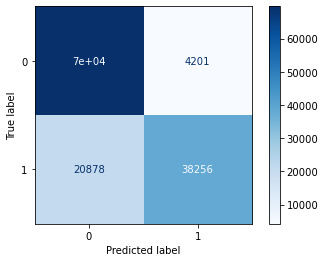

In [71]:
evaluate_model(xgb, X_train_reduced, y_train)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     52965
           1       0.76      0.64      0.70     14784

    accuracy                           0.88     67749
   macro avg       0.83      0.79      0.81     67749
weighted avg       0.87      0.88      0.87     67749

Area bajo la curva ROC:              0.8638
Area bajo la curva Precision-Recall: 0.7622


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


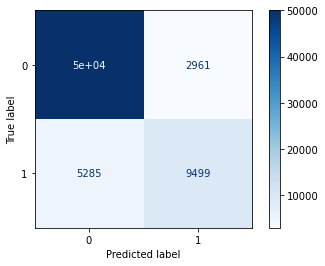

In [72]:
evaluate_model(xgb, X_test_reduced, y_test)